In [1]:
from fastai.vision.all import *

In [2]:
set_seed(6349649)

In [3]:
import timm

In [4]:
timm.list_models('convnext*')

['convnext_base',
 'convnext_base_384_in22ft1k',
 'convnext_base_in22ft1k',
 'convnext_base_in22k',
 'convnext_large',
 'convnext_large_384_in22ft1k',
 'convnext_large_in22ft1k',
 'convnext_large_in22k',
 'convnext_small',
 'convnext_tiny',
 'convnext_tiny_hnf',
 'convnext_xlarge_384_in22ft1k',
 'convnext_xlarge_in22ft1k',
 'convnext_xlarge_in22k']

In [5]:
DATASETS_DIR = Path(os.environ['DATASETS_DIR'])/'sorghum-id-fgvc-9'
DATASETS_DIR.ls()

(#4) [Path('/datasets/sorghum-id-fgvc-9/train_cultivar_mapping.csv'),Path('/datasets/sorghum-id-fgvc-9/test'),Path('/datasets/sorghum-id-fgvc-9/train_images'),Path('/datasets/sorghum-id-fgvc-9/sample_submission.csv')]

In [6]:
(DATASETS_DIR/'train_images').ls()

(#22194) [Path('/datasets/sorghum-id-fgvc-9/train_images/2017-06-19__13-06-29-651.png'),Path('/datasets/sorghum-id-fgvc-9/train_images/2017-06-03__12-58-24-135.png'),Path('/datasets/sorghum-id-fgvc-9/train_images/2017-06-15__12-32-43-241.png'),Path('/datasets/sorghum-id-fgvc-9/train_images/2017-06-01__11-31-50-488.png'),Path('/datasets/sorghum-id-fgvc-9/train_images/2017-06-02__16-25-06-191.png'),Path('/datasets/sorghum-id-fgvc-9/train_images/2017-06-28__12-52-56-384.png'),Path('/datasets/sorghum-id-fgvc-9/train_images/2017-06-05__12-08-56-198.png'),Path('/datasets/sorghum-id-fgvc-9/train_images/2017-06-13__11-37-46-365.png'),Path('/datasets/sorghum-id-fgvc-9/train_images/2017-06-26__18-27-33-812.png'),Path('/datasets/sorghum-id-fgvc-9/train_images/2017-06-27__11-00-20-408.png')...]

In [7]:
(DATASETS_DIR/'test').ls()

(#23639) [Path('/datasets/sorghum-id-fgvc-9/test/1320211956.png'),Path('/datasets/sorghum-id-fgvc-9/test/1460752465.png'),Path('/datasets/sorghum-id-fgvc-9/test/1437601570.png'),Path('/datasets/sorghum-id-fgvc-9/test/1053653999.png'),Path('/datasets/sorghum-id-fgvc-9/test/937061344.png'),Path('/datasets/sorghum-id-fgvc-9/test/1526324826.png'),Path('/datasets/sorghum-id-fgvc-9/test/1295561477.png'),Path('/datasets/sorghum-id-fgvc-9/test/993820791.png'),Path('/datasets/sorghum-id-fgvc-9/test/1054144892.png'),Path('/datasets/sorghum-id-fgvc-9/test/1911037980.png')...]

In [8]:
pd.read_csv(DATASETS_DIR/'train_cultivar_mapping.csv').head()

,image,cultivar
0,2017-06-16__12-24-20-930.png,PI_257599
1,2017-06-02__16-48-57-866.png,PI_154987
2,2017-06-12__13-18-07-707.png,PI_92270
3,2017-06-22__13-18-06-841.png,PI_152651
4,2017-06-26__12-56-48-642.png,PI_176766


In [9]:
pd.read_csv(DATASETS_DIR/'sample_submission.csv').head()

,filename,cultivar
0,1000005362.png,PI_152923
1,1000099707.png,PI_152923
2,1000135300.png,PI_152923
3,1000136796.png,PI_152923
4,1000292439.png,PI_152923


In [10]:
files = get_image_files(DATASETS_DIR/"train_images")
len(files)

22193

In [11]:
files[0]

Path('/datasets/sorghum-id-fgvc-9/train_images/2017-06-19__13-06-29-651.png')

In [12]:
df = pd.read_csv(DATASETS_DIR/'train_cultivar_mapping.csv')
df.head()

,image,cultivar
0,2017-06-16__12-24-20-930.png,PI_257599
1,2017-06-02__16-48-57-866.png,PI_154987
2,2017-06-12__13-18-07-707.png,PI_92270
3,2017-06-22__13-18-06-841.png,PI_152651
4,2017-06-26__12-56-48-642.png,PI_176766


In [13]:
# sampled_df = df.sample(frac=0.2, replace=False, random_state=2)
sampled_df = df

In [14]:
MODEL = 'convnext_small'
BS = 4*6
RESIZE_TO = 32*20
ITEM_TFMS = RandomResizedCrop(RESIZE_TO, min_scale=0.3)
BATCH_TFMS = aug_transforms()
METRICS = error_rate

In [15]:
dls = ImageDataLoaders.from_df(sampled_df, 
                               DATASETS_DIR/'train_images',
                               bs = BS,
                               item_tfms=ITEM_TFMS,
                               batch_tfms=BATCH_TFMS)

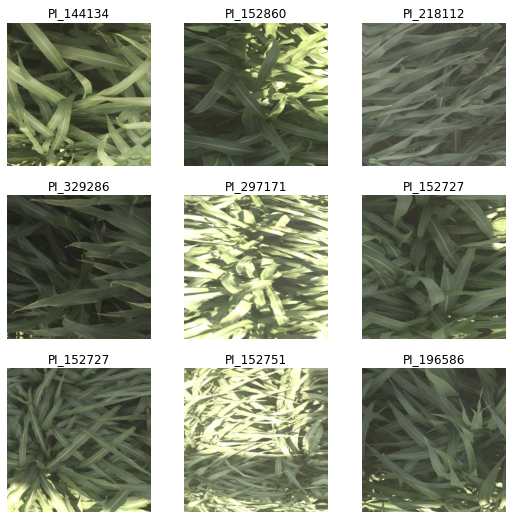

In [16]:
dls.show_batch()

In [17]:
learn = vision_learner(dls, MODEL, metrics=METRICS).to_fp16()

SuggestedLRs(valley=0.0012022644514217973)

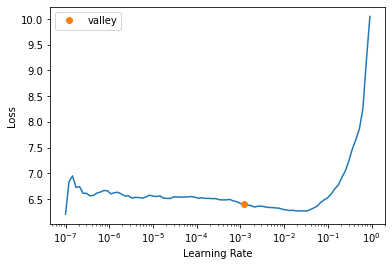

In [18]:
learn.lr_find()

In [19]:
callbacks = [
    SaveModelCallback(monitor='valid_loss',
                      fname=f'{MODEL}-frozen-10ep')
]

In [20]:
learn.fit_one_cycle(10,
                    lr_max=slice(3e-4,3e-3),
                    cbs=callbacks)

epoch,train_loss,valid_loss,error_rate,time
0,4.506487,4.742203,0.891393,05:34
1,2.676611,1.912795,0.517801,05:34
2,1.762559,1.224648,0.360297,05:31
3,1.316668,0.876365,0.264984,05:34
4,1.066516,0.679812,0.210680,05:40
5,0.889817,0.487913,0.155475,05:32
6,0.808847,0.428039,0.131591,05:31
7,0.683480,0.372748,0.118747,05:31
8,0.624204,0.363214,0.118297,05:31
9,0.567284,0.346696,0.111987,05:31


Better model found at epoch 0 with valid_loss value: 4.7422027587890625.
Better model found at epoch 1 with valid_loss value: 1.9127953052520752.
Better model found at epoch 2 with valid_loss value: 1.2246475219726562.
Better model found at epoch 3 with valid_loss value: 0.8763653039932251.
Better model found at epoch 4 with valid_loss value: 0.6798115372657776.
Better model found at epoch 5 with valid_loss value: 0.4879128932952881.
Better model found at epoch 6 with valid_loss value: 0.4280390739440918.
Better model found at epoch 7 with valid_loss value: 0.37274834513664246.
Better model found at epoch 8 with valid_loss value: 0.36321431398391724.
Better model found at epoch 9 with valid_loss value: 0.34669575095176697.


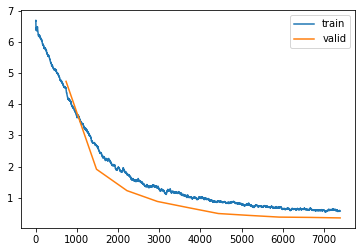

In [21]:
learn.recorder.plot_loss()

In [18]:
learn.load(f'{MODEL}-frozen-10ep')

/conda/envs/py310-cuda116/lib/python3.10/site-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


In [19]:
learn.unfreeze()

SuggestedLRs(valley=3.311311274956097e-06)

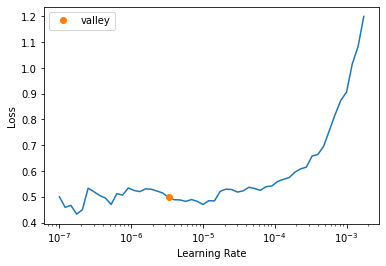

In [20]:
learn.lr_find()

In [22]:
callbacks = [
    SaveModelCallback(monitor='valid_loss', 
                      fname=f'{MODEL}-unfrozen-60ep')
]

In [23]:
learn.fit_one_cycle(60,
                    lr_max=slice(1e-6, 1e-5),
                    cbs=callbacks)

epoch,train_loss,valid_loss,error_rate,time
0,0.579345,0.350622,0.112663,07:06
1,0.594511,0.358252,0.114466,07:04
2,0.607427,0.367441,0.117395,07:00
3,0.563776,0.351559,0.113565,07:03
4,0.531190,0.332767,0.106580,07:04
5,0.545839,0.347377,0.113790,07:00
6,0.558260,0.348501,0.112213,07:00
7,0.559575,0.351195,0.114917,07:00
8,0.563327,0.349363,0.115142,07:01
9,0.567151,0.325043,0.107030,07:01


Better model found at epoch 0 with valid_loss value: 0.3506219685077667.
Better model found at epoch 4 with valid_loss value: 0.33276650309562683.
Better model found at epoch 9 with valid_loss value: 0.3250432014465332.
Better model found at epoch 11 with valid_loss value: 0.31448689103126526.
Better model found at epoch 13 with valid_loss value: 0.3108650743961334.
Better model found at epoch 17 with valid_loss value: 0.3005932569503784.
Better model found at epoch 19 with valid_loss value: 0.29454976320266724.
Better model found at epoch 22 with valid_loss value: 0.2923591136932373.
Better model found at epoch 24 with valid_loss value: 0.2835862338542938.
Better model found at epoch 30 with valid_loss value: 0.2640984356403351.
Better model found at epoch 33 with valid_loss value: 0.2613450586795807.
Better model found at epoch 35 with valid_loss value: 0.25662150979042053.
Better model found at epoch 36 with valid_loss value: 0.24674679338932037.
Better model found at epoch 49 with 

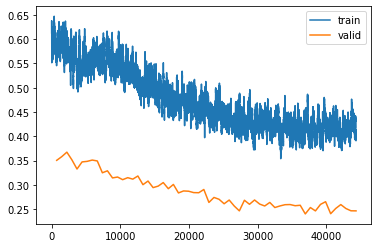

In [24]:
learn.recorder.plot_loss()

In [18]:
learn.load(f'{MODEL}-unfrozen-60ep')

/conda/envs/py310-cuda116/lib/python3.10/site-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


In [19]:
learn.unfreeze()

SuggestedLRs(valley=2.2908675418875646e-06)

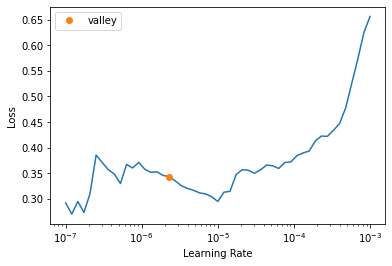

In [20]:
learn.lr_find()

In [21]:
callbacks = [SaveModelCallback(monitor='error_rate', 
                               fname=f'{MODEL}-unfrozen-1-15ep'),
            ReduceLROnPlateau(monitor='valid_loss',
                              min_delta=0.1,
                              patience=2)]

In [22]:
learn.fit_one_cycle(15,
                    lr_max=slice(1e-6, 5e-6),
                    cbs=callbacks
                   )

epoch,train_loss,valid_loss,error_rate,time
0,0.408422,0.248202,0.080442,07:05
1,0.434071,0.255512,0.083371,07:04
2,0.412400,0.257490,0.085399,07:01
3,0.392832,0.241176,0.079090,07:02
4,0.364108,0.242159,0.078414,07:02
5,0.402588,0.254188,0.084948,07:02
6,0.421539,0.246454,0.079090,07:02
7,0.389513,0.244051,0.080216,07:02
8,0.383878,0.245365,0.078414,07:04
9,0.395451,0.235177,0.075034,07:04


Better model found at epoch 0 with error_rate value: 0.08044163137674332.
Epoch 2: reducing lr to 4.540040393828708e-07
Better model found at epoch 3 with error_rate value: 0.0790896788239479.
Better model found at epoch 4 with error_rate value: 0.0784137025475502.
Epoch 4: reducing lr to 4.849555950849857e-07
Epoch 6: reducing lr to 4.0399075305876157e-07
Epoch 8: reducing lr to 2.762283020211177e-07
Better model found at epoch 9 with error_rate value: 0.07503379136323929.
Epoch 10: reducing lr to 1.4049575185635183e-07
Better model found at epoch 12 with error_rate value: 0.07345650345087051.
Epoch 12: reducing lr to 3.80426922790091e-08
Epoch 14: reducing lr to 5.017866449534959e-12


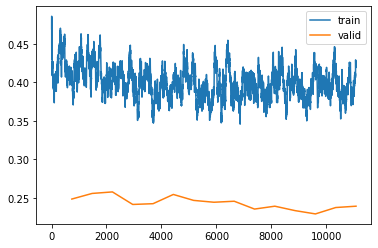

In [23]:
learn.recorder.plot_loss()

In [29]:
test_files = get_image_files(DATASETS_DIR/"test")
len(test_files)

23639

In [30]:
test_files

(#23639) [Path('/datasets/sorghum-id-fgvc-9/test/1320211956.png'),Path('/datasets/sorghum-id-fgvc-9/test/1460752465.png'),Path('/datasets/sorghum-id-fgvc-9/test/1437601570.png'),Path('/datasets/sorghum-id-fgvc-9/test/1053653999.png'),Path('/datasets/sorghum-id-fgvc-9/test/937061344.png'),Path('/datasets/sorghum-id-fgvc-9/test/1526324826.png'),Path('/datasets/sorghum-id-fgvc-9/test/1295561477.png'),Path('/datasets/sorghum-id-fgvc-9/test/993820791.png'),Path('/datasets/sorghum-id-fgvc-9/test/1054144892.png'),Path('/datasets/sorghum-id-fgvc-9/test/1911037980.png')...]

In [31]:
test_dl = learn.dls.test_dl(test_files)

In [32]:
tta_preds, _ = learn.tta(dl=test_dl)

In [33]:
decoded = tta_preds.argmax(dim=1)

In [34]:
learn.dls.vocab[decoded]

(#23639) ['PI_180348','PI_22913','PI_302252','PI_152733','PI_63715','PI_144134','PI_145619','PI_152961','PI_175919','PI_154987'...]

In [35]:
fieldnames = ['filename', 'cultivar']
predictions = [{'filename': f.name, 'cultivar': c} 
               for f,c in zip(test_files, learn.dls.vocab[decoded])]

In [36]:
import csv
  
with open(f'{MODEL}-predictions.csv', 'w') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames = fieldnames)
    writer.writeheader()
    writer.writerows(predictions)